In [42]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.QuasarCatalog.quasar_pop import QuasarRate

import matplotlib.pyplot as plt
import corner

from slsim.Plots.lens_plots import LensingPlots
import tqdm

## Lensed quasar + host galaxy population

This notebook shows how to simulate lensed quasar population with/without host galaxies.

In [43]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
galaxy_sky_area = Quantity(value=10, unit="deg2")
quasar_sky_area = Quantity(value=10, unit="deg2")
full_sky_area = Quantity(value=10, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 30, "z_min": 0.01, "z_max": 5}
kwargs_source_cut = {"z_min": 0.001, "z_max": 5.0}

In [44]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=None,
)

In [45]:
# Initiate deflector population class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

/home/paras/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/home/paras/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [46]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)

# quasar sample without host galaxy
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30, host_galaxy=False)

# quasar sample with host galaxy
quasar_source_plus_galaxy = quasar_class.quasar_sample(
    m_min=15, m_max=30, host_galaxy=True
)

Matching quasars with host galaxies (Optimized):   2%|▏         | 2322/105726 [00:33<26:07, 65.96it/s]/home/paras/repos/self/slsim/slsim/Sources/QuasarCatalog/quasar_host_match.py:121: RuntimeWarning: divide by zero encountered in log10
  M_bol = M_bol_sun - 2.5 * np.log10(L_bol)  # L_sun
Matching quasars with host galaxies (Optimized): 100%|██████████| 105726/105726 [25:44<00:00, 68.46it/s]


In [47]:
quasar_source

z,M_i,ps_mag_i
float64,float64,float64
2.673305881792089,-23.156811947270718,22.699280982619257
2.213978540095596,-16.910254266382562,28.50540477574676
1.0334680339650513,-13.65266976021199,29.96749154582042
1.0333885180302622,-16.1462584003735,27.473775785979488
0.6264251798959436,-12.607134219613206,29.83986023320452
3.348085476620236,-20.886805056014744,25.50217539574152
2.221293175906685,-16.673282532390825,28.7524431111131
2.580820370677798,-19.87424969193132,25.939948076489497
0.375664503833339,-11.632680775087907,29.6923659519832


In [48]:
quasar_source_plus_galaxy

z,M_i,ps_mag_i,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_g,mag_r,mag_i,mag_z,mag_y,vel_disp,black_hole_mass_exponent,eddington_ratio
,,,,,,kpc,,rad,,,,,,,,
float64,float64,float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.673305881792089,-23.156811947270718,22.699280982619257,-19.83828472830498,0.16924050356384102 .. 0.0006003561429943962,0.2899547911815041,1.2687352557133624,59922093215.85168,7.737921143278499e-07,28.715927965445044,28.684609352433032,28.5220552599956,28.487871659815024,28.251093526952555,128.44295765466472,7.649001415894321,0.8186850777281418
2.213978540095596,-16.910254266382562,28.50540477574676,-16.58007338991252,0.2714831848593701 .. 0.03810980451501702,0.2778850121041636,1.0404192464455153,1074330333.0106037,6.117078378946095e-07,29.92884720738141,29.776518803668992,29.68848872588579,29.577205793249504,29.37966636115003,40.04317489922515,5.431925160502917,0.428060208892785
1.0334680339650513,-13.65266976021199,29.96749154582042,-14.166027432378012,0.35612202923290565 .. 0.29696719385627435,0.23614638243938835,0.5591487913003642,25163859.852839712,3.366468680753931e-07,30.16291173101458,29.913516626888722,29.59902418709379,29.23617346562989,29.144594457541416,27.892459635253413,4.744082554901175,0.1
1.0333885180302622,-16.1462584003735,27.473775785979488,-17.368276502542933,0.008962804572639435 .. 0.048727677857727414,0.5343254934182635,1.6264701915971294,2280596106.9202576,9.755306503618961e-07,27.544975781848464,27.115431859095104,26.6924050316318,26.12314375563679,25.876172453267145,42.47956654486809,5.544279048422522,0.16351632559550489
0.6264251798959436,-12.607134219613206,29.83986023320452,-12.78541564865559,0.15542404540623625 .. 0.4470287213149874,0.09966916911656326,1.0818470431151077,6402979.469110302,7.825787408737001e-07,30.26877407589585,29.726290247020977,29.380490036805725,29.31379238369034,29.2222428124903,23.462564622164408,4.41509492308355,0.11237269589908436
3.348085476620236,-20.886805056014744,25.50217539574152,-20.9746590990136,0.7335445328858603 .. 0.17153370784927427,0.7834986110234483,2.269349258376465,24407957703.99139,1.4803949378996237e-06,26.275804168241038,25.950444185664843,25.86340256523132,25.771804226744848,25.682700029636138,99.84153007576165,7.169833491339212,0.30497395998654214
2.221293175906685,-16.673282532390825,28.7524431111131,-16.2554760838673,0.14426651964908788 .. 0.06761219830671389,0.42438620914065484,0.5878156584820945,608446204.7324327,3.4566763071670314e-07,30.526795731353474,30.307949001236835,30.164120901555748,29.98200893157511,29.730013709553106,38.202967394533374,5.342435601222945,0.4228792992401782
2.580820370677798,-19.87424969193132,25.939948076489497,-19.381768647609643,0.06410646951919031 .. 0.05654920949034216,0.398952232024402,1.9111221605551594,7264444248.636693,1.154325003665934e-06,27.956803739656735,27.743522883268113,27.507591653228232,27.490687553501402,27.28034192650214,66.70854377185255,6.402765108649117,0.7018532696898944


In [49]:
# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r", "g"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
}

In [50]:
# Initiate source population classes.

# Point source quasar population without host galaxy
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    # catalog_type="skypy",
    pointsource_type="quasar",
    **kwargs_quasar,
)

# Point source quasar population with host galaxy
source_quasar_plus_galaxies = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=quasar_source_plus_galaxy,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    catalog_type="skypy",
    pointsource_type="quasar",
    extendedsource_type="single_sersic",
    **kwargs_quasar,
)

In [51]:
# Initiate LensPop class to generate lensed quasar pop. We simulate lens pop in 500
# deg^2. If you want to simulate in larger sky, change sky area to your requirement.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

quasar_plus_galaxies_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar_plus_galaxies,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

## Properties of the lensed quasar population

Text(0.5, 1.05, 'Quasar Source Population')

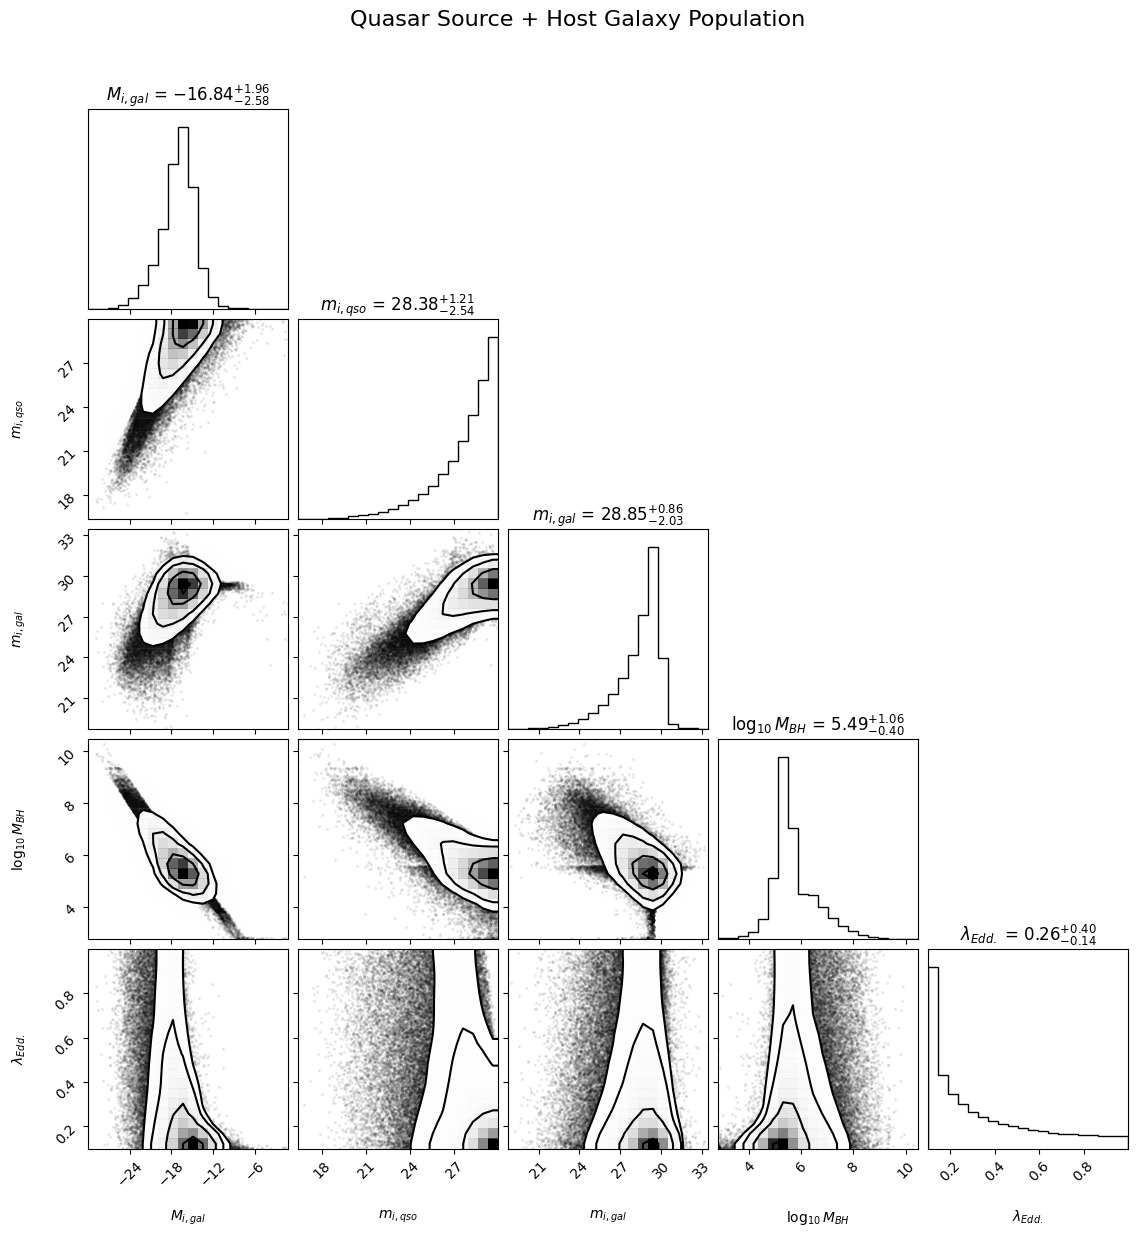

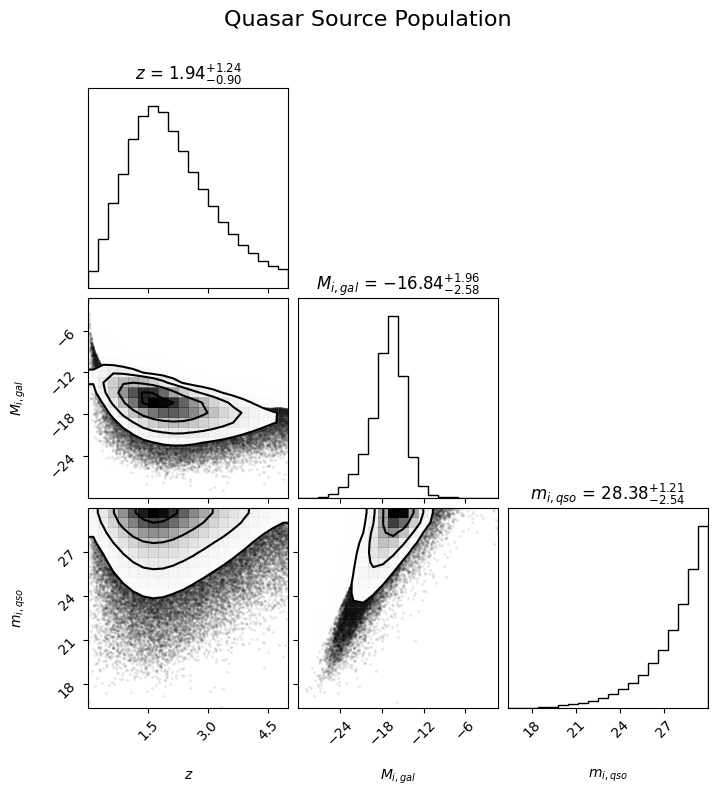

In [52]:
# we make a corner plot for both the lens populations

keys = [
    # "z",
    "M_i",
    "ps_mag_i",
    "mag_i",
    "black_hole_mass_exponent",
    "eddington_ratio",
]

key_labels = {
    "z": r"$z$",
    "M_i": r"$M_{i, gal}$",
    "ps_mag_i": r"$m_{i, qso}$",
    "mag_i": r"$m_{i, gal}$",
    "black_hole_mass_exponent": r"$\log_{10} M_{BH}$",
    "eddington_ratio": r"$\lambda_{Edd.}$",
}

data_qso_plus_gal = {key: quasar_source_plus_galaxy[key] for key in keys}

fig = corner.corner(
    data_qso_plus_gal,
    labels=[key_labels[key] for key in keys],
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth=True,
)
fig.suptitle(
    "Quasar Source + Host Galaxy Population",
    fontsize=16,
    y=1.05,
)

data_qso_only = {key: quasar_source[key] for key in ["z", "M_i", "ps_mag_i"]}

fig = corner.corner(
    data_qso_only,
    labels=[key_labels[key] for key in data_qso_only.keys()],
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth=True,
)
fig.suptitle(
    "Quasar Source Population",
    fontsize=16,
    y=1.05,
)

## Plot lenses

In [53]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 4,
    "max_image_separation": 30,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
}

quasar_plot = LensingPlots(quasar_lens_pop, num_pix=64, coadd_years=10)
quasar_plus_galaxies_plot = LensingPlots(
    quasar_plus_galaxies_lens_pop, num_pix=64, coadd_years=10
)

In [ ]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 2,
    # "max_image_separation": 30,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
    "second_brightest_image_cut": {"r": 24, "i": 24, "g": 24},
}

quasar_plot = LensingPlots(quasar_lens_pop, num_pix=64, coadd_years=10)
quasar_plus_galaxies_plot = LensingPlots(quasar_plus_galaxies_lens_pop, num_pix=64, coadd_years=10)

# select lenses for plotting
selected_lenses_quasar = []
selected_lenses_quasar_plus_galaxies = []

for _ in tqdm.trange(16, desc="Selecting lenses at random"):
    selected_lenses_quasar.append(
        quasar_lens_pop.select_lens_at_random(
            **kwargs_lens_cut_plot,
        )
    )
    selected_lenses_quasar_plus_galaxies.append(
        quasar_plus_galaxies_lens_pop.select_lens_at_random(
            **kwargs_lens_cut_plot,
        )
    )

# get rgb images of the selected lenses
rgb_images_quasar = []
rgb_images_quasar_plus_galaxies = []

for i in tqdm.trange(len(selected_lenses_quasar), desc="Generating RGB images"):
    rgb_images_quasar.append(
        quasar_plot.rgb_image(
            selected_lenses_quasar[i],
            rgb_band_list=["i", "r", "g"],
        )
    )
    rgb_images_quasar_plus_galaxies.append(
        quasar_plus_galaxies_plot.rgb_image(
            selected_lenses_quasar_plus_galaxies[i],
            rgb_band_list=["i", "r", "g"],
        )
    )

print(f"Number of selected lenses [quasar]: {len(selected_lenses_quasar)}")
print(f"Number of selected lenses [quasar + host galaxy]: {len(selected_lenses_quasar_plus_galaxies)}")


Selecting lenses at random:   0%|          | 0/16 [00:00<?, ?it/s]

/home/paras/.local/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/home/paras/.local/lib/python3.12/site-packages/lenstronomy/LensModel/Util/epl_util.py:21: RuntimeWarning: invalid value encountered in scalar divide
  return (x3**2 * (y1 - y2) + x1**2 * (y2 - y3) + x2**2 * (-y1 + y3)) / div
/home/paras/.local/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.local/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.local/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = sup

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

Selecting lenses at random:   6%|▋         | 1/16 [00:25<06:25, 25.71s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

Selecting lenses at random:  12%|█▎        | 2/16 [01:05<07:55, 33.99s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

Selecting lenses at random:  19%|█▉        | 3/16 [01:47<08:09, 37.64s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

Selecting lenses at random:  25%|██▌       | 4/16 [02:28<07:49, 39.09s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


Selecting lenses at random:  31%|███▏      | 5/16 [02:51<06:06, 33.34s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


Selecting lenses at random:  38%|███▊      | 6/16 [02:55<03:52, 23.24s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

Selecting lenses at random:  44%|████▍     | 7/16 [03:16<03:23, 22.56s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

Selecting lenses at random:  50%|█████     | 8/16 [03:53<03:37, 27.21s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


Selecting lenses at random:  56%|█████▋    | 9/16 [04:02<02:29, 21.30s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

Selecting lenses at random:  62%|██████▎   | 10/16 [04:21<02:03, 20.57s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


Selecting lenses at random:  69%|██████▉   | 11/16 [04:55<02:03, 24.67s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


Selecting lenses at random:  75%|███████▌  | 12/16 [05:21<01:40, 25.17s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

Selecting lenses at random:  81%|████████▏ | 13/16 [05:50<01:18, 26.30s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

Selecting lenses at random:  88%|████████▊ | 14/16 [06:30<01:00, 30.41s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


Selecting lenses at random:  94%|█████████▍| 15/16 [06:32<00:21, 21.92s/it]

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


Generating RGB images: 100%|██████████| 16/16 [00:02<00:00,  7.87it/s]

Number of selected lenses [quasar]: 16
Number of selected lenses [quasar + host galaxy]: 16


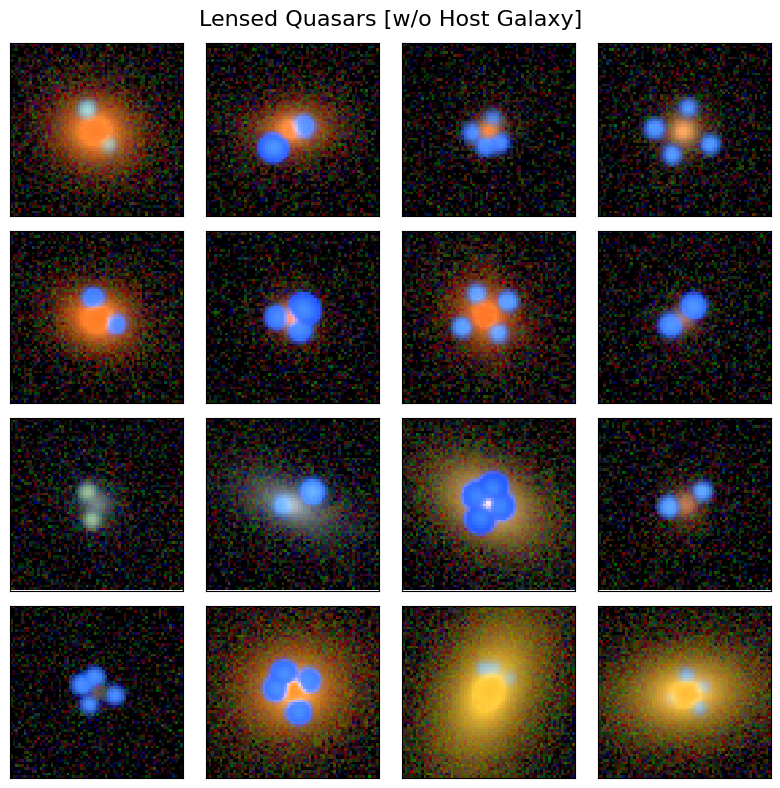

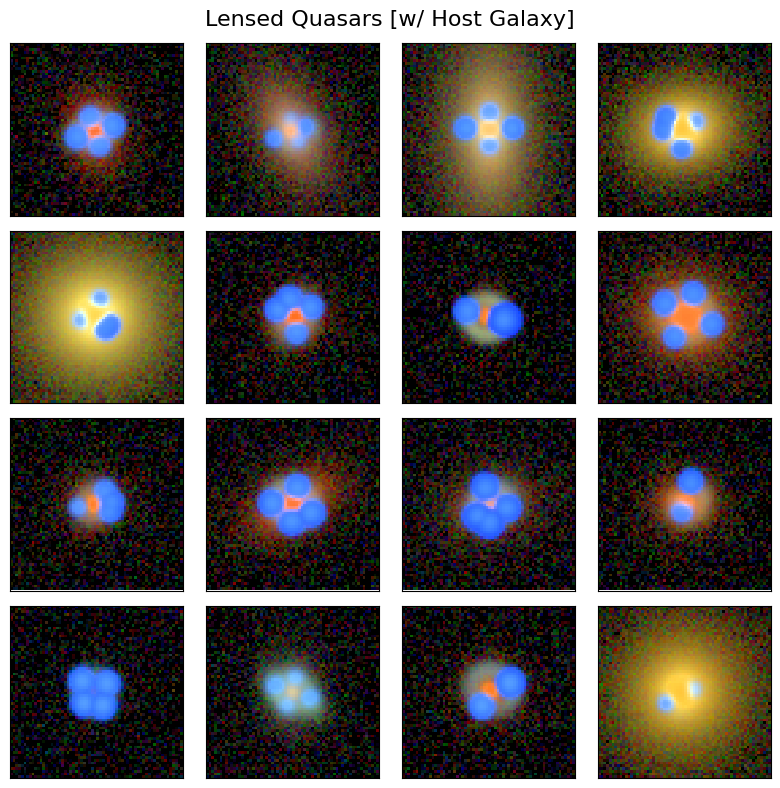

In [ ]:
# make montage of the rgb images for both the lens populations

# quasar lens montage
fig, ax = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(8, 8),
    subplot_kw={"xticks": [], "yticks": []},
)
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(
            rgb_images_quasar[i * 4 + j],
            origin="lower",
            interpolation="nearest",
        )
fig.suptitle("Lensed Quasars [w/o Host Galaxy]", fontsize=16)
# fig.subplots_adjust(top=0.9)
fig.tight_layout()

# quasar + host galaxy lens montage
fig, ax = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(8, 8),
    subplot_kw={"xticks": [], "yticks": []},
)
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(
            rgb_images_quasar_plus_galaxies[i * 4 + j],
            origin="lower",
            interpolation="nearest",
        )
fig.suptitle("Lensed Quasars [w/ Host Galaxy]", fontsize=16)
# fig.subplots_adjust(top=0.9)
fig.tight_layout()

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

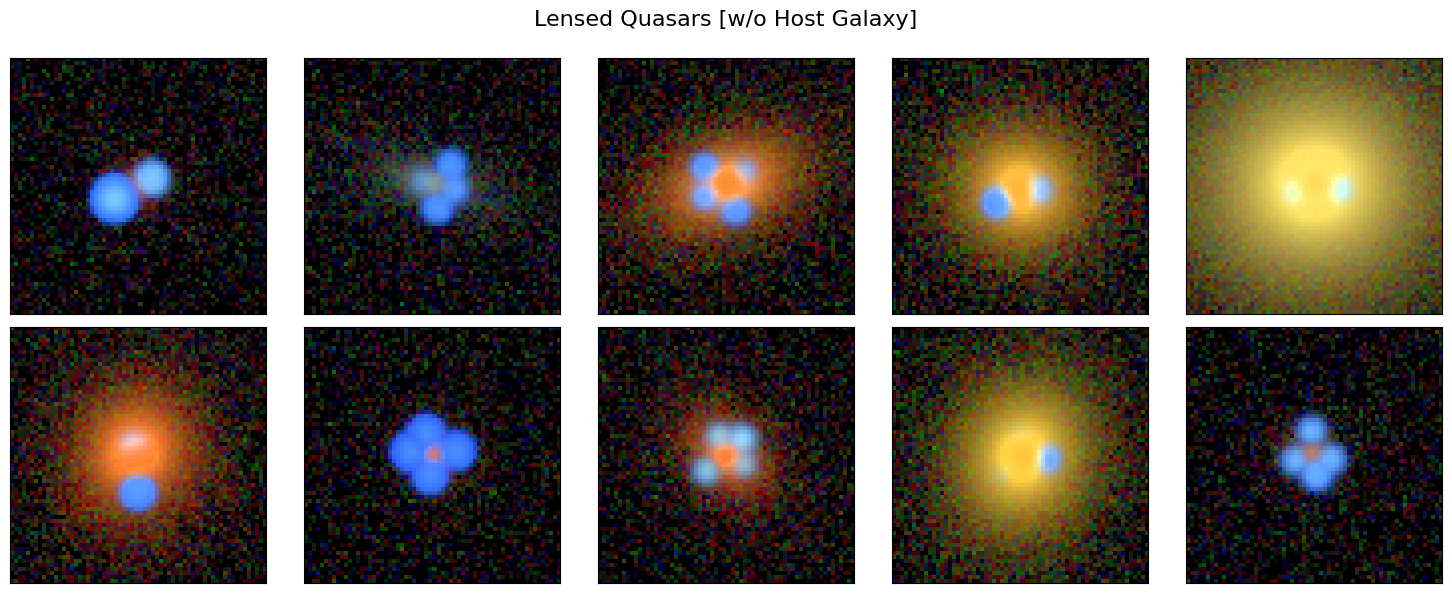

In [56]:
# generate montage indicating which bands are used for the rgb color image
fig, axes = quasar_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
fig.suptitle("Lensed Quasars [w/o Host Galaxy]", fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

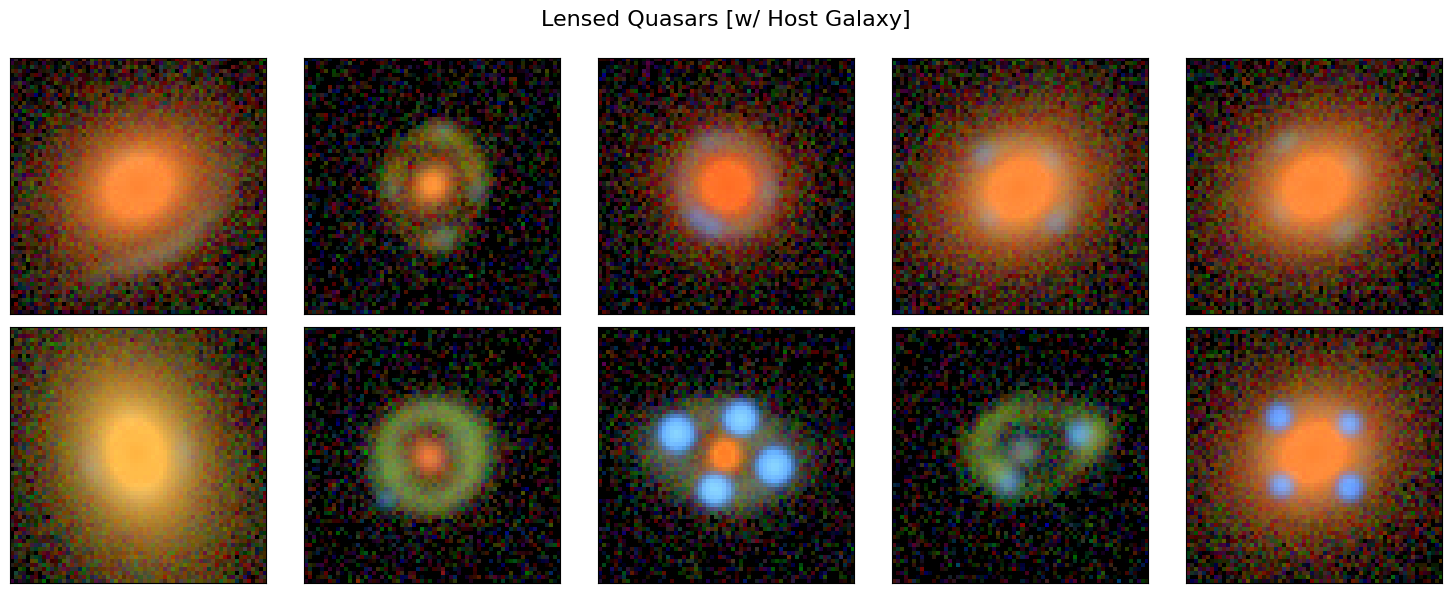

In [60]:
# generate montage indicating which bands are used for the rgb color image
fig, axes = quasar_plus_galaxies_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
fig.suptitle("Lensed Quasars [w/ Host Galaxy]", fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()